#### корректировка и подготовка данных к прогнозированию

  Для прогнозирования полезно исключить данные, которые неоправданно сильно выбиваются из общих данных. 

Аномальные значения могут иметь различную природу. Некоторые аномальные значения могут быть объяснены дополнительными данными, например аномально низкая температура может повлечь за собой аномально высокое потребление тепловой энергии. Цель определения аномальных значений в этой работе – это моделирование потребления в “нормальных условиях”, исключение ложных показаний, которые возникли по различным причинам (ошибочный ручной ввод в систему), либо показаний, которые не могут быть объяснены в рамках имеющихся данных.  Если оставить их в данных, эти выбросы будут мешать модели определить правильные зависимости в данных.  


Подготовка данных:
- Корректировка нетипичного потребления (необъяснимый скачок/спад потребления).

Корректировать нестандартные события можно несколькими способами:
- Усреднение по двум соседним точкам.
- Скользящая средняя.
- Результаты предыдущего периода.
- Данные за аналогичный период в прошлые годы.
- Экспертное заключение.



#### Загрузка данных и библиотек


In [3]:
%run ../libs/libs.py

In [5]:
#%run f2forecast.py

In [6]:
#imp.reload(db)

In [12]:
import imp
from pandas.plotting import scatter_matrix

from adtk.data import validate_series
from adtk.visualization import plot
from adtk.detector import ThresholdAD
from adtk.detector import OutlierDetector
#import .libs.libs
import prediction as p

In [13]:
from adtk.pipe import Pipeline
from adtk.transformer import ClassicSeasonalDecomposition
from adtk.detector import QuantileAD

In [16]:
config = "C:/Users/msson/energy_artefacts/conf/gisee_test.json.example"#gisee_test
engine = db.db_connect(config)

The configuration file has been loaded.


Загрузим файл с данными:

In [17]:
id_voc_com_resource = 10 # тепловая энергия
id_md_building = '13287'  
id_org_building = '43821'
id_metering_device = '13051'
df_13287 = db.get_informaion_from_first_forecast_qisee(engine, id_voc_com_resource, id_md_building, id_org_building)
df, res = p.preparing_data(df_13287)

OperationalError: (psycopg2.OperationalError) could not connect to server: Connection timed out (0x0000274C/10060)
	Is the server running on host "10.97.1.82" and accepting
	TCP/IP connections on port 5432?

(Background on this error at: http://sqlalche.me/e/e3q8)

In [346]:
#df = validate_series(df)
#print(df)

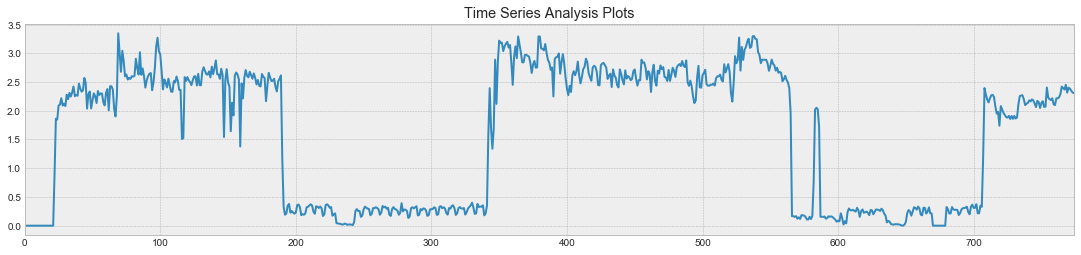

In [57]:
tsplot_only(np.array(df.ec_d))

#### Выявление и корректировка анномалий

Для выявления аномалий будем использовать квантили. Значения, выбивающиеся за промежуток 10-95 квантилей, обозначаются аномальными.

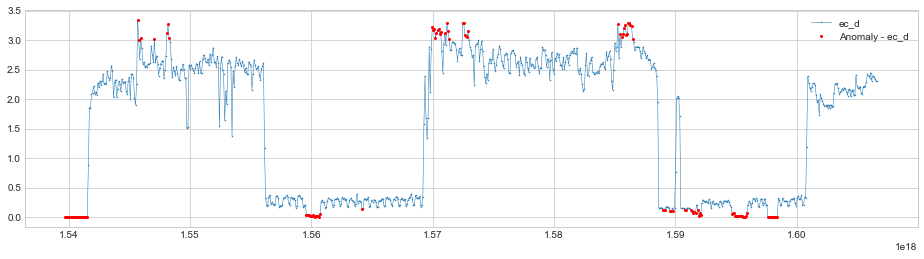

In [371]:
from adtk.pipe import Pipeline
from adtk.transformer import ClassicSeasonalDecomposition
from adtk.detector import QuantileAD

steps = [("quantile_ad", QuantileAD(high=0.95, low=0.10))]
pipeline = Pipeline(steps)

s = validate_series(df)
anomalies_ts1 = pipeline.fit_detect(s)
plot(s, anomaly=anomalies_ts, ts_markersize=1, anomaly_markersize=2, anomaly_tag="marker", anomaly_color='red');


На графике видно, что если определять аномалии таким способом, то упускаются аномалии с минимальными значениями в зимнем периоде и максимальными в летний. Поэтому будем делить ряд на 2 сезонные составляющие, и в каждой из них находить свои аномалии. Функция деления ряда на 2 подряда описана в блоке "Кластеризация".

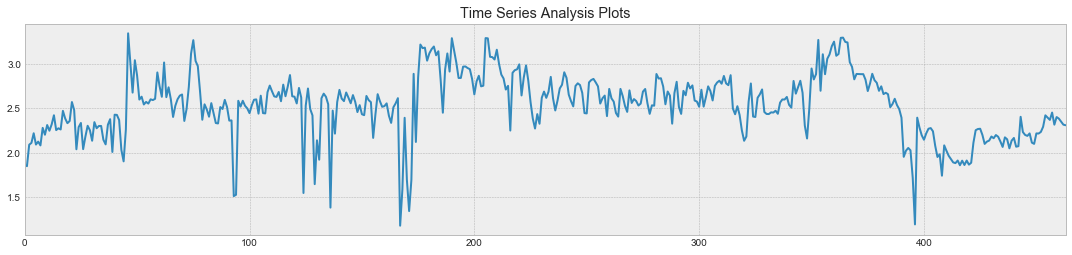

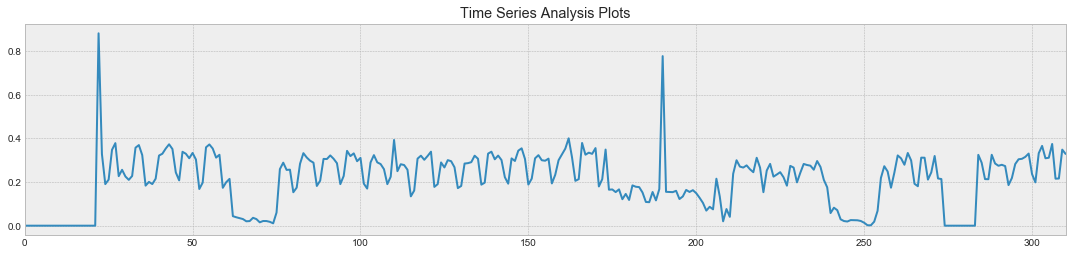

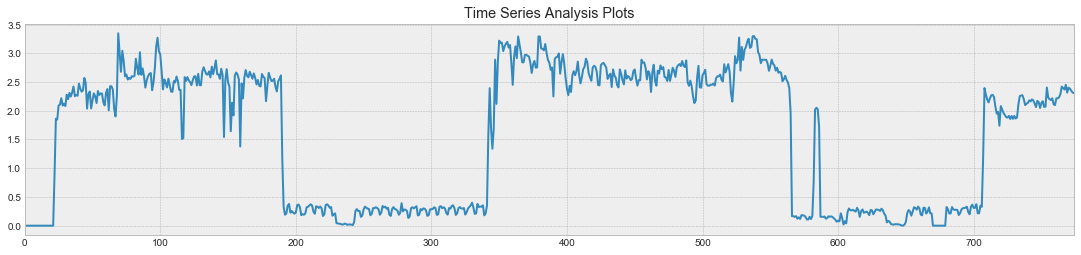

In [372]:
winter, summer = distributions_division(df.ec_d)
tsplot_only(np.array(df.ec_d))
#df.ec_d.hist(bins=10)

зимний период

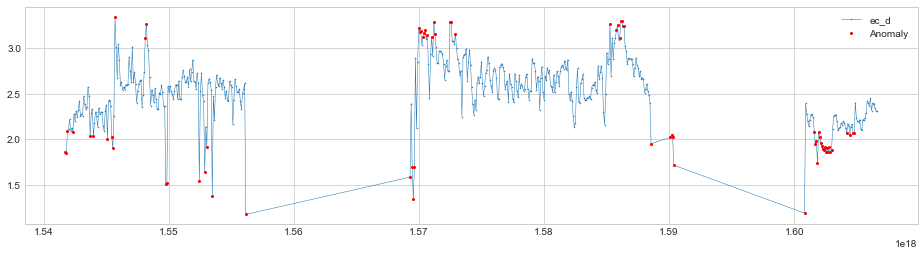

In [373]:
s = validate_series(winter)
anomalies_ts2 = pipeline.fit_detect(s)
plot(s, anomaly=anomalies_ts2, ts_markersize=1, anomaly_markersize=2, anomaly_tag="marker", anomaly_color='red');


летний период

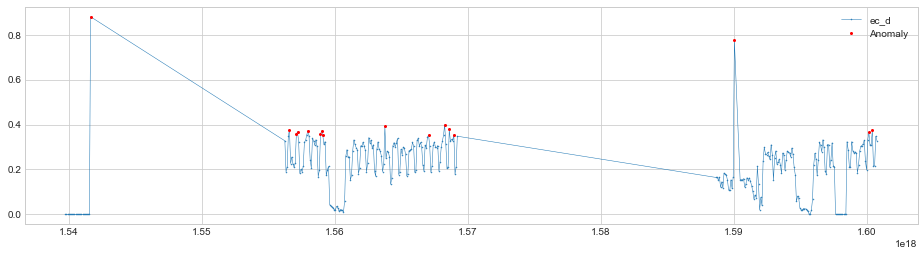

In [374]:
s = validate_series(summer)
anomalies_ts3 = pipeline.fit_detect(s)
plot(s, anomaly=anomalies_ts3, ts_markersize=1, anomaly_markersize=2, anomaly_tag="marker", anomaly_color='red');


В конечном итоге аномальными значениями будем считать значение, если оно оказалось аномальным хотя бы в одном методе определения 

In [375]:
anomalies_ts1.ec_d[anomalies_ts2.index[0]:anomalies_ts2.index[-1]] = anomalies_ts1.ec_d[anomalies_ts2.index[0]:anomalies_ts2.index[-1]] | anomalies_ts2
anomalies_ts1.ec_d[anomalies_ts3.index[0]:anomalies_ts3.index[-1]] = anomalies_ts1.ec_d[anomalies_ts3.index[0]:anomalies_ts3.index[-1]] | anomalies_ts3

финальные аномалии:

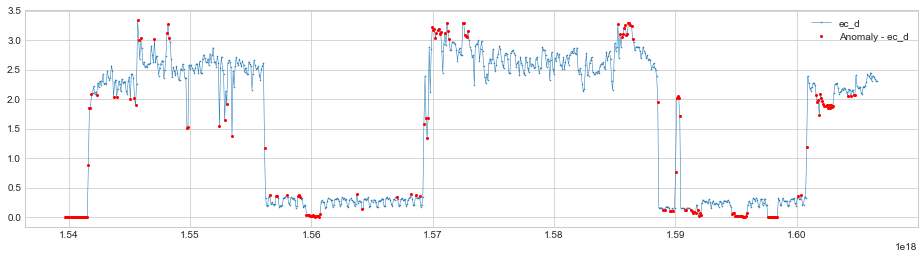

In [376]:
s = validate_series(df[df.index[0]: df.index[-1]])
#anomalies_ts1 = pipeline.fit_detect(s)
plot(s, anomaly=anomalies_ts1, ts_markersize=1, anomaly_markersize=2, anomaly_tag="marker", anomaly_color='red');


Далее мы убираем из выявленных аномалий те значения, которые могут быть объяснены с помощью дополнительных данных

#### Аномалии относительно температуры - корреляция


Для того, чтобы понять на сколько один ряд влияет на другой, мы будем использовать смотреть на корреляцию. Если корреляция между двумя временными точками < -0.75 (теоретически, температура обратно пропорциональна потреблению), то считаем, что аномальное значение объяснимо. 

In [381]:
anomalies_corr = anomalies_ts1.copy()

Получим температурные данные:

In [422]:
exog_temp = db.get_temperature(engine)

exog_temp.index = pd.to_datetime(exog_temp.index)
exog = pd.DataFrame(index = exog_temp.index.values, columns=['temperature'])
exog_temp = exog_temp.groupby(exog_temp.index).first()
exog_temp = exog_temp.reindex(pd.date_range(exog_temp.index[0], exog_temp.index[-1], freq='D'), fill_value=0)
exog_temp = exog_temp[df.index[0]: df.index[-1]]

df['temperature'] = np.array(exog_temp.temperature)


aaaaaaaaaa


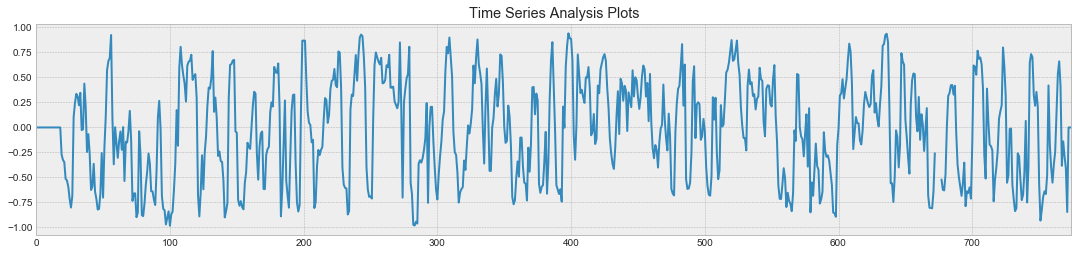

In [357]:
# считаем корреляцию
r_window_size = 7
rolling_r = df['ec_d'].rolling(window=r_window_size, center=True).corr(df['temperature']).fillna(0)
tsplot_only(np.array(rolling_r))

In [358]:
anomalies_corr.loc[rolling_r < -0.75  ] = False

Также смотрим на корреляцию 1, 2 лагов 

In [359]:
df['temperature'] = np.array(exog_temp.shift(1).fillna(0).temperature)
rolling_r1 = df['ec_d'].rolling(window=r_window_size, center=True).corr(df['temperature']).fillna(0)
anomalies_corr.loc[rolling_r1 < -0.75  ] = False

In [360]:
df['temperature'] = np.array(exog_temp.shift(2).fillna(0).temperature)
rolling_r2 = df['ec_d'].rolling(window=r_window_size, center=True).corr(df['temperature']).fillna(0)
anomalies_corr.loc[rolling_r2 < -0.75  ] = False

Совсем финальные аномалии

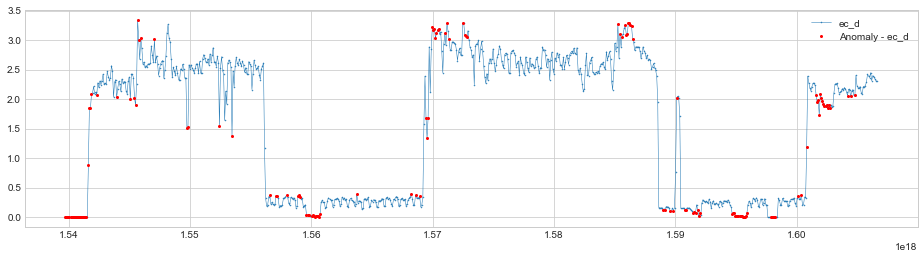

In [361]:
s = validate_series(df)
plot(s.ec_d, anomaly=anomalies_corr, ts_markersize=1, anomaly_markersize=2, anomaly_tag="marker", anomaly_color='red');

сглаживание аномалий

In [362]:
#Усреднение по двум соседним точкам.          averge
#Скользящая средняя.                          moving_average
#Результаты предыдущего периода.              last_period 
#Данные за аналогичный период в прошлые годы. last_year_period
#Экспертное заключение.

def delete_anomalies(df, anomalies, type = 'average', num = 7):
    
    if (type == 'average'):
        df_ans = df.copy()
        new_df = (df_ans.shift(1) + df_ans.shift(-1)) / 2
        df_ans.loc[anomalies.ec_d == True] = new_df.loc[anomalies.ec_d == True]
        return df_ans
    if (type == 'moving_average'):
        df_ans = df.copy()
        new_df = df_ans.rolling(num, min_periods=1).mean()
        df_ans.loc[anomalies.ec_d == True] = new_df.loc[anomalies.ec_d == True]
        return df_ans
                
                
new_df = delete_anomalies(df, anomalies_corr, type = 'moving_average')


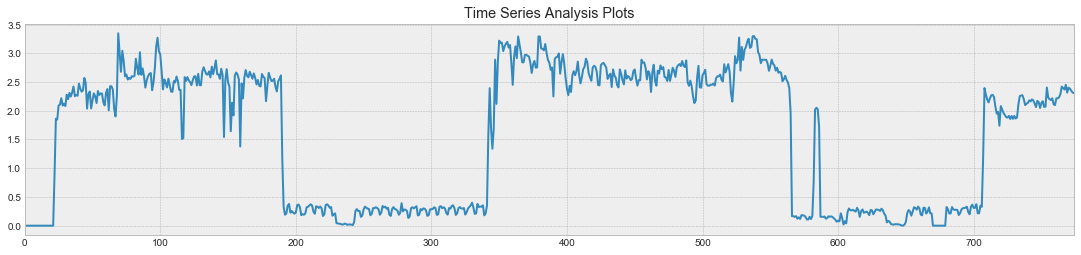

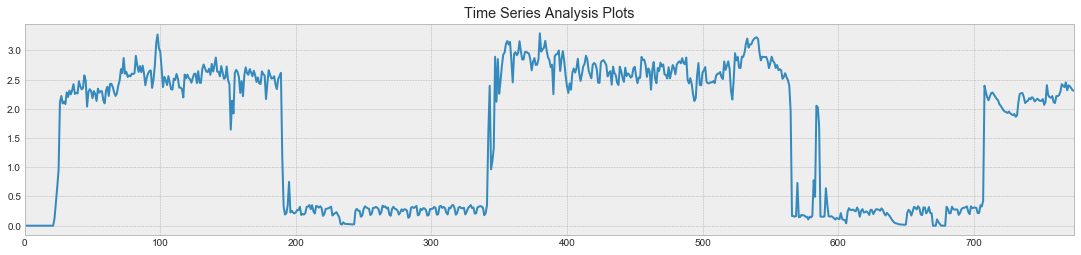

In [363]:
tsplot_only(np.array(df.ec_d))
tsplot_only(np.array(new_df.ec_d))

#### Аномалии относительно температуры - сравниваем аномальные даты

Для определения температурных аномалий не подходит метод квантилей - погода изменяется по синусоиде. Для определения температурных аномалий используем следующий метод:
* Сглаживаем ряд, оставляя средний "годовой тренд"
* Считаем его допустимые отклонения (+-k градусов)
* Все значения, которые отклоняются от допустимой нормы считаем аномальными

Затем мы сравниваем аномальные значения временного ряда и ряда потребления и оставляем аномальными только те значения, которые не объясняются аномалиями температуры.

In [456]:
anomalies_comp = anomalies_ts1.copy()

1) Сглаживание с помощью усреднения значений. Тут возникают трудности: простое сглаживание дает не достаточное качество, получается довольно рваный ряд (с большими изменениями за короткий промежуток времени) со смещением вниз или вверх. При попытке увеличить окно, получается сильное смещение

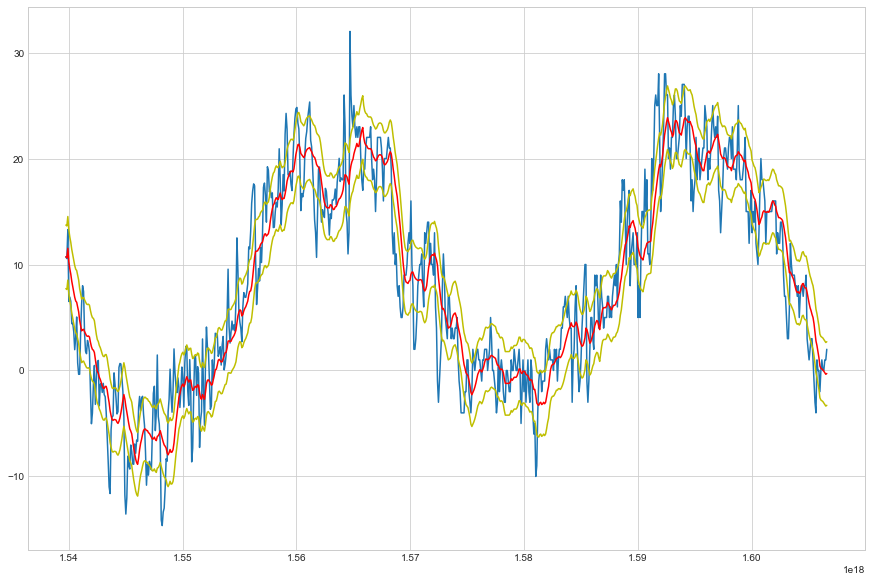

In [279]:
fig = plt.figure(figsize=(15, 10))
plt.plot(df['temperature'])
plt.plot(df['temperature'].rolling(window=14, min_periods=1).mean(), 'r-')
plt.plot(df['temperature'].rolling(window=14, min_periods=1).mean() + 3, 'y-')
plt.plot(df['temperature'].rolling(window=14, min_periods=1).mean() - 3, 'y-')

a = (df['temperature'] < df['temperature'].rolling(window=10, min_periods=1).mean() - 3) 
b = (df['temperature'] < df['temperature'].rolling(window=10, min_periods=1).mean() - 3)

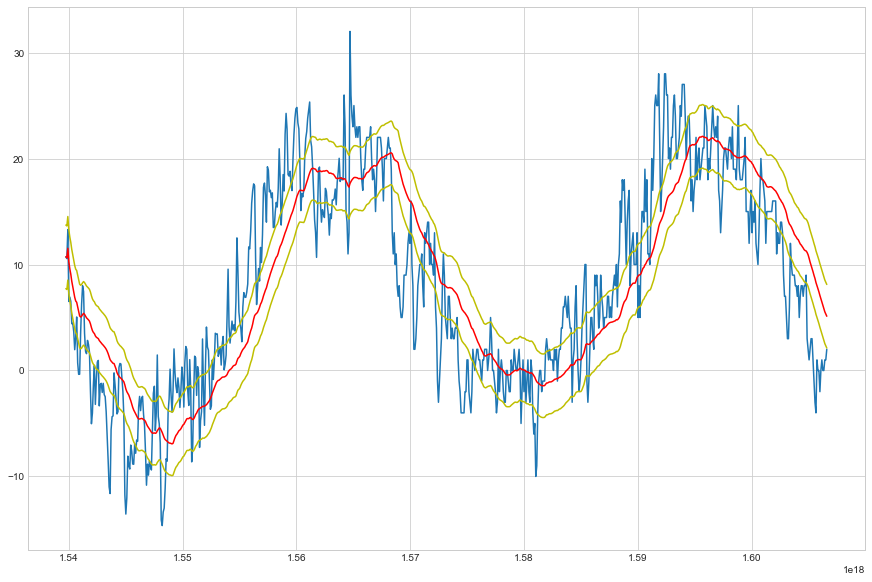

In [278]:
fig = plt.figure(figsize=(15, 10))
plt.plot(df['temperature'])
plt.plot(df['temperature'].rolling(window=50, min_periods=1).mean(), 'r-')
plt.plot(df['temperature'].rolling(window=50, min_periods=1).mean() + 3, 'y-')
plt.plot(df['temperature'].rolling(window=50, min_periods=1).mean() - 3, 'y-')

a = (df['temperature'] < df['temperature'].rolling(window=10, min_periods=1).mean() - 3) 
b = (df['temperature'] < df['temperature'].rolling(window=10, min_periods=1).mean() - 3)


2) Сглаживание ряда с помощью фильтра Савицкого–Голея. Сглаживание происходим с помощью свертки, путем подгонки последовательных подмножеств смежных точек данных полиномом низкой степени методом линейных наименьших квадратов. 

Результат получается лучше, чем в первом случае.


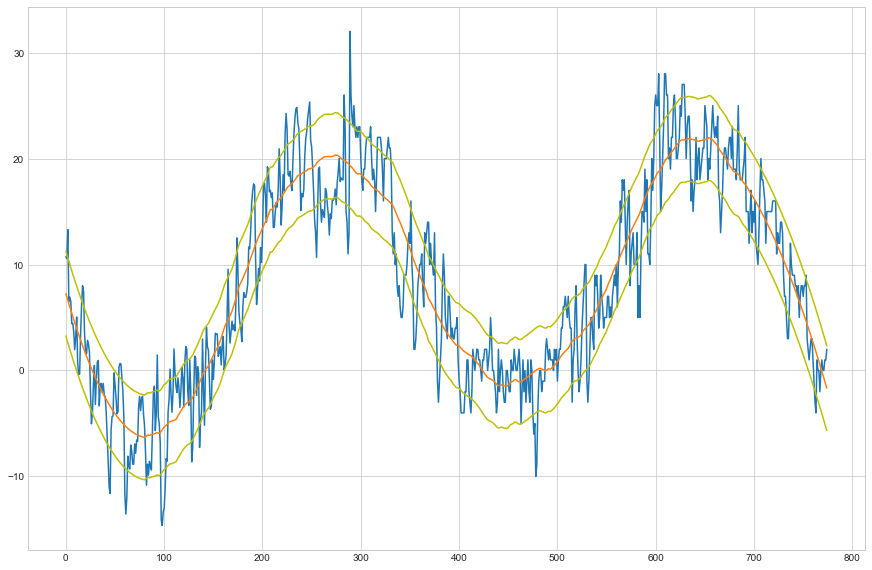

In [290]:
from scipy.signal import savgol_filter
fig = plt.figure(figsize=(15, 10))

np.set_printoptions(precision=2)  # For compact display.
x = np.array(df['temperature'])


savgol_filter(x, 5, 2)
sf = savgol_filter(x, 161, 2)#, mode='nearest'
plt.plot(range(len(x)), x)
plt.plot(range(len(sf)), sf)
plt.plot(range(len(sf)), sf + 4, 'y-')
plt.plot(range(len(sf)), sf - 4, 'y-')

a = np.array(df['temperature'] < sf - 4) 
b = np.array(df['temperature'] > sf + 4)
c = [a | b]

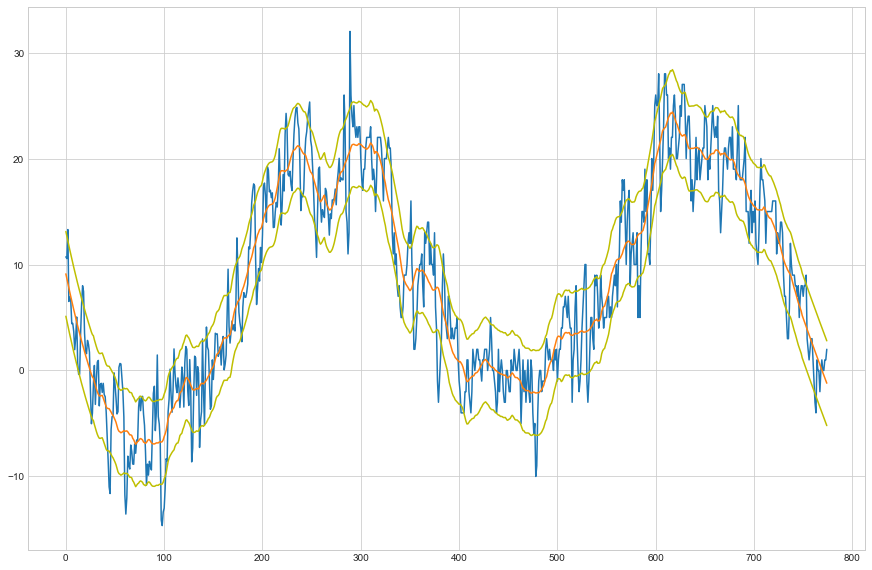

In [425]:
from scipy.signal import savgol_filter
fig = plt.figure(figsize=(15, 10))

np.set_printoptions(precision=2)  # For compact display.
x = np.array(df['temperature'])


savgol_filter(x, 5, 2)
sf = savgol_filter(x, 51, 2)#, mode='nearest'
plt.plot(range(len(x)), x)
plt.plot(range(len(sf)), sf)
plt.plot(range(len(sf)), sf + 4, 'y-')
plt.plot(range(len(sf)), sf - 4, 'y-')

a = np.array(df['temperature'] < sf - 4) 
b = np.array(df['temperature'] > sf + 4)
c = np.logical_or(a, b)
#c = [b[i] | a[i] for i in range(b)]

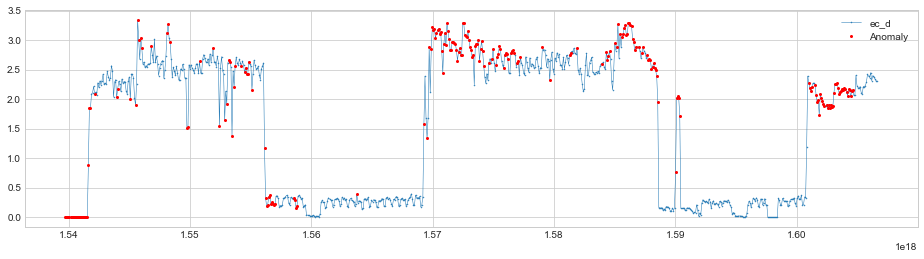

In [327]:
s = validate_series(df['ec_d'])
anomalies_comp = pipeline.fit_detect(s)
plot(s, anomaly=anomalies_comp, ts_markersize=1, anomaly_markersize=2, anomaly_tag="marker", anomaly_color='red');

In [463]:
def get_analogies(anomalies_ts, anomalies_wt):

    a = np.logical_and(anomalies_wt, anomalies_ts)
    anomalies_ts[a] = False
    return anomalies_ts

In [464]:
an = get_analogies(anomalies_comp.values.reshape([1, -1]), c)  
an = get_analogies(an, np.append(c[1:], False))  
an = get_analogies(an, np.append(c[2:], [False, False]))  

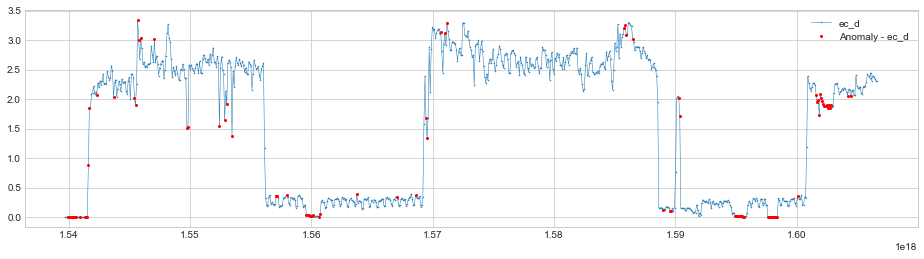

In [465]:
plot(s, anomaly=anomalies_comp, ts_markersize=1, anomaly_markersize=2, anomaly_tag="marker", anomaly_color='red');

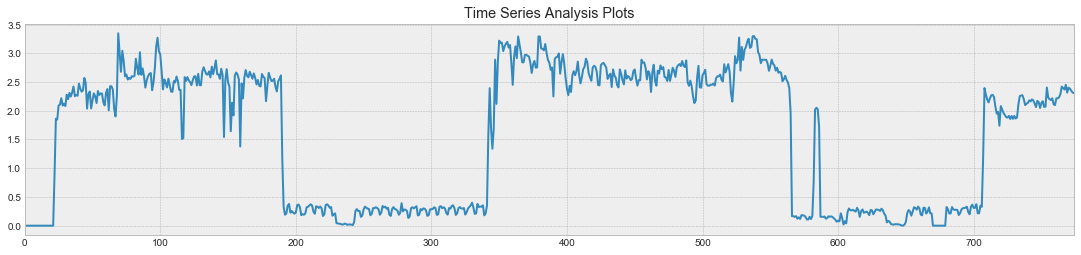

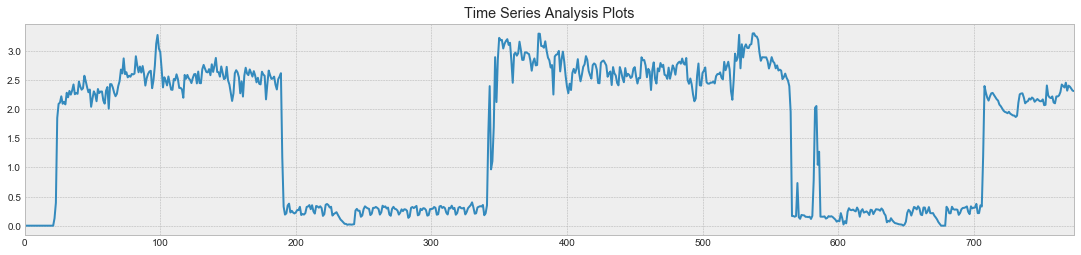

In [473]:
#Усреднение по двум соседним точкам.          averge
#Скользящая средняя.                          moving_average
#Результаты предыдущего периода.              last_period 
#Данные за аналогичный период в прошлые годы. last_year_period
#Экспертное заключение.

def delete_anomalies(df, anomalies, type = 'average', num = 7):
    
    if (type == 'average'):
        df_ans = df.copy()
        new_df = (df_ans.shift(1) + df_ans.shift(-1)) / 2
        df_ans.loc[anomalies == True] = new_df.loc[anomalies == True]
        return df_ans
    if (type == 'moving_average'):
        df_ans = df.copy()
        new_df = df_ans.rolling(num, min_periods=1).mean()
        #print(new_df)
        df_ans.loc[anomalies == True] = new_df.loc[anomalies == True]
        return df_ans
                

#print(an)
new_df = delete_anomalies(df, an[0], type = 'moving_average')

tsplot_only(np.array(df.ec_d))
tsplot_only(np.array(new_df.ec_d))